In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

In [49]:
df = pd.read_csv('Datasets/PTEN_MCF10A_predictions_ref_set_multi_copy.csv',
                index_col=False)
print(df.head(12))

   variant  MCF10A score  CADD  SNAP2  PolyPhen  SIFT  WT_RSA (%)  \
0      K6E        0.3311  26.6     67     0.155  0.99         NaN   
1      K6I        0.4544  27.3     64     0.244  1.00         NaN   
2     R15S        0.3870  25.0     65     0.123  1.00        53.3   
3     M35V        0.3606  25.0     44     0.914  1.00         0.0   
4     P38H        0.3521  26.1     44     1.000  1.00         0.0   
5     G44D        0.6232  26.0     65     0.968  1.00       117.5   
6     A79T        0.5711  23.0    -95     0.005  0.41        86.3   
7     D92N        0.2677  28.8     90     1.000  1.00        44.3   
8     H93Q        0.3301  26.1     77     1.000  1.00        74.5   
9     H93R        0.3930  27.0     83     0.998  0.97        74.5   
10   I101F        0.8803  26.0      6     0.998  1.00         0.2   
11   I101T        0.7138  29.0     44     0.998  1.00         0.2   

    WT_DEPTH (_)  WT_OSP  MT_RSA (%)  MT_DEPTH (_)  MT_OSP  ground truth  
0            NaN     NaN   

In [50]:
df['ground truth'].value_counts()

1.0    12
2.0     7
0.0     5
Name: ground truth, dtype: int64

In [34]:
# calculate macro-average roc
def mac_avg_roc(y_test, y_score):
    from scipy import interp
    
    # first ompute ROC curves and ROC areas for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points    
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC        
    mean_tpr /= n_classes
    
    fpr_macro = np.insert(all_fpr, 0, 0)
    tpr_macro = np.insert(mean_tpr, 0, 0)
    
    return fpr_macro, tpr_macro

In [35]:
fpr_MCF10A, tpr_MCF10A = mac_avg_roc(y, MCF10A_score)
roc_auc_MCF10A = auc(fpr_MCF10A, tpr_MCF10A)

In [36]:
print(fpr_MCF10A, '\n', tpr_MCF10A)

[0.         0.         0.05882353 0.16666667 1.        ] 
 [0.         0.33333333 0.67927171 0.88789683 1.        ]


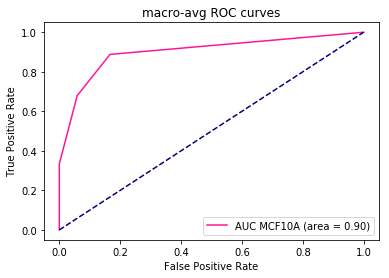

In [38]:
# plot macro-avg ROC
fig, ax = plt.subplots()

ax.plot(fpr_MCF10A, tpr_MCF10A,
         label='AUC MCF10A (area = {0:0.2f})'.format(roc_auc_MCF10A),
         color='deeppink')

ax.plot([0, 1], [0, 1], color='navy', linestyle='--')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('macro-avg ROC curves')
legend = ax.legend(loc="lower right")

plt.show()

In [39]:
# confusion matrix
from sklearn.metrics import confusion_matrix
 
y_true = df['ground truth']
y_predict = MCF10A_binned
cm = confusion_matrix(y_true, y_predict)
print(cm)

[[ 5  0  0]
 [ 0 11  1]
 [ 0  2  5]]


In [40]:
from sklearn.metrics import accuracy_score

accuracy_score(y, MCF10A_score)

0.875

In [41]:
from sklearn.metrics import f1_score

f1_score(y, MCF10A_score, average='micro')

0.875

# building and applying SVM

In [58]:
training_df = df.drop(df.iloc[:,2:6], axis=1).copy()

In [59]:
training_df

,variant,MCF10A score,WT_RSA (%),WT_DEPTH (_),WT_OSP,MT_RSA (%),MT_DEPTH (_),MT_OSP,ground truth
0,K6E,0.3311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,K6I,0.4544,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R15S,0.3870,53.3,3.6,0.32,52.3,3.6,0.37,NaN
3,M35V,0.3606,0.0,10.8,0.53,2.7,10.3,0.50,NaN
4,P38H,0.3521,0.0,10.5,0.60,0.0,11.3,0.62,NaN
5,G44D,0.6232,117.5,3.4,0.14,98.9,3.3,0.12,NaN
6,A79T,0.5711,86.3,3.1,0.19,80.2,3.2,0.19,2.0
7,D92N,0.2677,44.3,3.7,0.32,44.6,3.9,0.34,NaN
8,H93Q,0.3301,74.5,3.4,0.22,78.0,3.5,0.21,NaN
9,H93R,0.3930,74.5,3.4,0.22,79.1,3.4,0.16,NaN


In [60]:
training_df.dropna(inplace=True)

In [61]:
training_df.reset_index(drop=True)

,variant,MCF10A score,WT_RSA (%),WT_DEPTH (_),WT_OSP,MT_RSA (%),MT_DEPTH (_),MT_OSP,ground truth
0,A79T,0.5711,86.3,3.1,0.19,80.2,3.2,0.19,2.0
1,N117S,0.4916,25.3,4.0,0.51,10.1,4.0,0.53,1.0
2,H123Q,0.9934,0.0,11.0,0.60,0.0,11.4,0.64,1.0
3,H123Y,0.6383,0.0,11.0,0.60,0.0,12.1,0.58,1.0
4,C124S,0.8797,4.3,6.7,0.52,4.3,7.3,0.54,2.0
5,C124R,0.6986,4.3,6.7,0.52,8.1,5.8,0.48,2.0
6,A126D,0.5325,55.7,3.1,0.23,68.7,3.5,0.21,1.0
7,G127R,0.9753,0.0,5.2,0.49,0.0,8.3,0.74,2.0
8,G129R,0.8214,18.3,6.1,0.44,23.3,4.7,0.37,2.0
9,G129E,0.8841,18.3,6.1,0.44,4.5,7.3,0.61,2.0


In [62]:
training_df[['MCF10A score']].shape

(24, 1)

In [63]:
from sklearn import svm

SVM = svm.SVC(gamma='scale', decision_function_shape='ovo').fit(
    training_df[['MCF10A score']], training_df['ground truth']) 

In [64]:
SVM_pred = SVM.predict(df[['MCF10A score']])  

In [65]:
print(SVM_pred)

[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 2. 1. 1. 2. 1. 2. 1. 1. 2. 2. 2. 1. 2. 1.
 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 2. 0. 1.]


In [66]:
SVM_pred.shape

(47,)

In [67]:
# add SVM predicted values back to df
df['SVM'] = SVM_pred

In [68]:
df.sort_values(by='SVM')

,variant,MCF10A score,CADD,SNAP2,PolyPhen,SIFT,WT_RSA (%),WT_DEPTH (_),WT_OSP,MT_RSA (%),MT_DEPTH (_),MT_OSP,ground truth,SVM
45,P354Q,0.1768,22.0,-52,0.238,0.910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
42,D268E,0.1080,18.0,-89,0.007,0.000,55.5,3.6,0.30,51.0,3.5,0.28,0.0,0.0
41,N262S,0.1021,23.0,-63,0.007,0.790,86.7,3.4,0.20,85.1,3.3,0.19,0.0,0.0
38,N228S,0.1243,18.0,-78,0.007,0.260,108.4,3.3,0.15,105.2,3.0,0.15,0.0,0.0
7,D92N,0.2677,28.8,90,1.000,1.000,44.3,3.7,0.32,44.6,3.9,0.34,NaN,0.0
37,M198I,0.1821,22.0,-85,0.001,0.000,0.0,11.3,0.55,0.0,11.0,0.52,0.0,0.0
36,Y180H,0.1171,23.0,-78,0.000,0.470,54.0,3.8,0.35,54.7,3.6,0.33,0.0,0.0
34,R173H,0.2672,34.0,54,0.966,0.970,16.4,4.4,0.45,34.9,4.3,0.34,NaN,0.0
25,G132D,0.6304,31.0,92,1.000,0.970,0.0,11.0,0.64,0.0,10.4,0.72,1.0,1.0
27,M134I,0.6386,27.0,-15,0.977,1.000,0.0,10.5,0.53,0.0,11.4,0.56,NaN,1.0


In [70]:
df.to_csv('Output Datasets/SVM_redicted.csv')

In [73]:
SVM_pred = df.dropna(subset=['ground truth']).reset_index()

In [74]:
# sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)

accuracy_score(y_true, SVM_pred[['SVM']])

0.875